In [31]:
# === Cell 1: Load data dan fitur terpilih ===

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Load data hasil preprocessing
X_scaled = pd.read_csv("../data/processed/X_scaled.csv", dtype="float32")
y = pd.read_csv("../data/processed/y.csv", dtype="int8").squeeze()

# Load daftar fitur terpilih
with open("../data/processed/selected_features.json") as f:
    selected_features = json.load(f)

# Ambil hanya kolom fitur terpilih
X_selected = X_scaled[selected_features]

print(f"Jumlah fitur terpilih: {len(selected_features)}")
print(f"Shape data lengkap: {X_selected.shape}")
print(f"Distribusi label: {y.value_counts().to_dict()}")


Jumlah fitur terpilih: 30
Shape data lengkap: (2768674, 30)
Distribusi label: {1: 2242880, 0: 525794}


In [32]:
# === Cell 2: Split data train/val/test ===

X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (1771951, 30), Val: (442988, 30), Test: (553735, 30)


In [33]:
# === Cell 3: Train model LightGBM ===

from lightgbm import LGBMClassifier, early_stopping

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

print("✅ Training selesai")


[LightGBM] [Info] Number of positive: 1435443, number of negative: 336508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6512
[LightGBM] [Info] Number of data points in the train set: 1771951, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.0011987
✅ Training selesai


In [34]:
# === Cell 4: Evaluasi dasar ===

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.9999843791535619

Classification Report:
               precision    recall  f1-score   support

           0     0.9986    0.9995    0.9990    105159
           1     0.9999    0.9997    0.9998    448576

    accuracy                         0.9996    553735
   macro avg     0.9992    0.9996    0.9994    553735
weighted avg     0.9996    0.9996    0.9996    553735


Confusion Matrix:
 [[105102     57]
 [   150 448426]]


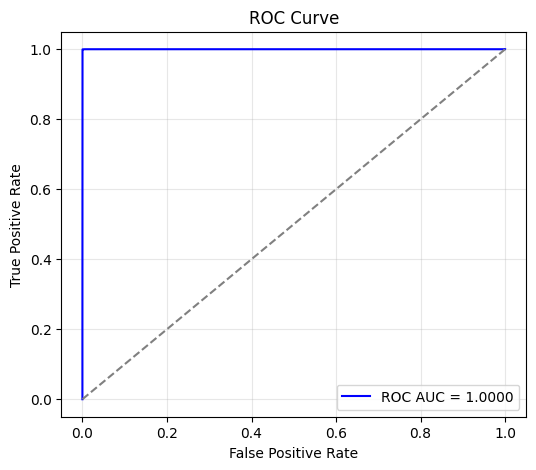

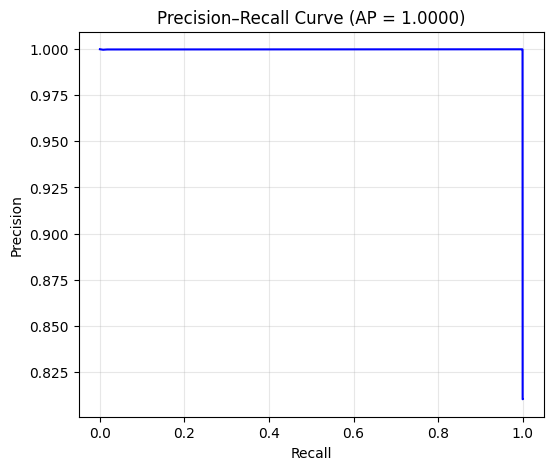

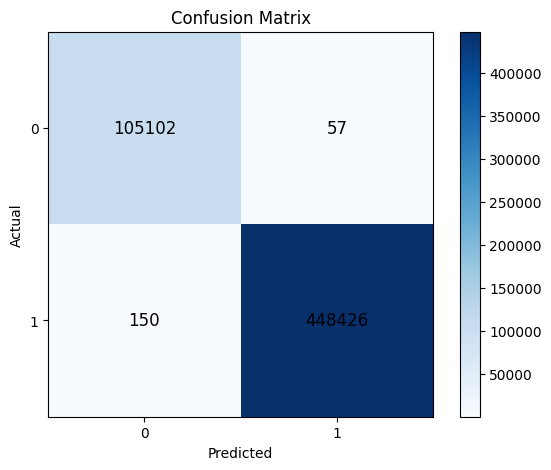

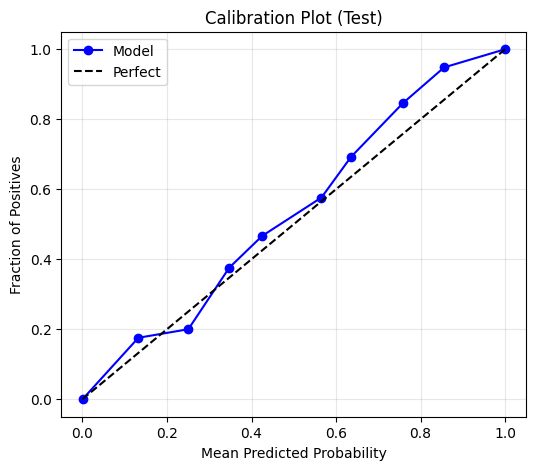

In [35]:
# === Cell 5: Evaluasi Visual Lengkap untuk LightGBM ===

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
import numpy as np

# ---------------- ROC Curve ----------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ---------------- Precision–Recall Curve ----------------
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="blue")
plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.show()


# ---------------- Confusion Matrix (Blue–White) ----------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Labeling
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Tulisan angka
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=12)

plt.show()


# ---------------- Calibration Plot ----------------
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Model", color="blue")
plt.plot([0,1], [0,1], "--", color="black", label="Perfect")
plt.title("Calibration Plot (Test)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [5]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [36]:
# ==============================
# 1️⃣ Siapkan library & data
# ==============================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

# Dataset
X_train_np = X_train.astype("float32").to_numpy()
X_val_np   = X_val.astype("float32").to_numpy()
X_test_np  = X_test.astype("float32").to_numpy()

y_train_np = y_train.astype("float32").to_numpy().reshape(-1,1)
y_val_np   = y_val.astype("float32").to_numpy().reshape(-1,1)
y_test_np  = y_test.astype("float32").to_numpy().reshape(-1,1)

# Teacher probabilities
teacher_train = lgbm.predict_proba(X_train)[:,1].reshape(-1,1).astype("float32")
teacher_val   = lgbm.predict_proba(X_val)[:,1].reshape(-1,1).astype("float32")

In [37]:
# ==============================
# 2️⃣ Soft labels via logit + temperature
# ==============================
T = 5  # temperature

def soft_labels_from_teacher(probs, T=5):
    probs = np.clip(probs, 1e-6, 1-1e-6)
    logits = np.log(probs / (1 - probs))
    return tf.nn.sigmoid(logits / T).numpy()

teacher_soft_train = soft_labels_from_teacher(teacher_train, T=T)
teacher_soft_val   = soft_labels_from_teacher(teacher_val, T=T)

In [38]:
# ==============================
# 3️⃣ Weighted pos/neg untuk imbalance
# ==============================
pos_weight = len(y_train_np[y_train_np==0]) / len(y_train_np[y_train_np==1])
sample_weight = np.where(y_train_np.flatten()==1, pos_weight, 1.0)

# ==============================
# 4️⃣ Buat student model
# ==============================
student = Sequential([
    Input(shape=(X_train_np.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [39]:
# ==============================
# 5️⃣ Definisi loss + optimizer
# ==============================
alpha = 0.5  # tradeoff hard vs soft label

ce_loss_fn = tf.keras.losses.BinaryCrossentropy()
kl_loss_fn = tf.keras.losses.KLDivergence()
optimizer   = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

@tf.function
def train_step(x, y_true, y_teacher_soft, sample_weight):
    with tf.GradientTape() as tape:
        y_pred = student(x, training=True)
        # Weighted CE
        ce_loss = ce_loss_fn(y_true, y_pred, sample_weight=sample_weight)
        # KL loss
        y_pred_safe = tf.clip_by_value(y_pred, 1e-6, 1-1e-6)
        student_logit = tf.math.log(y_pred_safe / (1 - y_pred_safe))
        student_soft = tf.nn.sigmoid(student_logit / T)
        kl_loss = kl_loss_fn(y_teacher_soft, student_soft)
        # Total loss
        loss = alpha * ce_loss + (1-alpha) * kl_loss
    grads = tape.gradient(loss, student.trainable_variables)
    optimizer.apply_gradients(zip(grads, student.trainable_variables))
    return loss

In [40]:
# ==============================
# 6️⃣ Dataset & training loop
# ==============================
batch_size = 4096
train_ds = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np, teacher_soft_train, sample_weight))
train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np, teacher_soft_val))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


EPOCHS = 50
for epoch in range(EPOCHS):
    losses = []
    for x, y_true, y_teacher_soft, sw in train_ds:
        loss = train_step(x, y_true, y_teacher_soft, sw)
        losses.append(float(loss))
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {np.mean(losses):.6f}")


Epoch 1/50 - Loss: 32.616706
Epoch 2/50 - Loss: 3.078480
Epoch 3/50 - Loss: 1.274380
Epoch 4/50 - Loss: 0.543355
Epoch 5/50 - Loss: 0.252229
Epoch 6/50 - Loss: 0.128534
Epoch 7/50 - Loss: 0.095453
Epoch 8/50 - Loss: 0.082828
Epoch 9/50 - Loss: 0.054742
Epoch 10/50 - Loss: 0.061882
Epoch 11/50 - Loss: 0.046219
Epoch 12/50 - Loss: 0.048200
Epoch 13/50 - Loss: 0.041860
Epoch 14/50 - Loss: 0.037443
Epoch 15/50 - Loss: 0.038789
Epoch 16/50 - Loss: 0.034773
Epoch 17/50 - Loss: 0.035664
Epoch 18/50 - Loss: 0.035830
Epoch 19/50 - Loss: 0.029718
Epoch 20/50 - Loss: 0.031815
Epoch 21/50 - Loss: 0.026892
Epoch 22/50 - Loss: 0.030278
Epoch 23/50 - Loss: 0.026966
Epoch 24/50 - Loss: 0.026993
Epoch 25/50 - Loss: 0.025404
Epoch 26/50 - Loss: 0.026044
Epoch 27/50 - Loss: 0.026274
Epoch 28/50 - Loss: 0.023208
Epoch 29/50 - Loss: 0.021068
Epoch 30/50 - Loss: 0.020135
Epoch 31/50 - Loss: 0.023531
Epoch 32/50 - Loss: 0.034681
Epoch 33/50 - Loss: 0.021506
Epoch 34/50 - Loss: 0.025240
Epoch 35/50 - Loss: 0.

In [41]:
# ==============================
# 7️⃣ Evaluasi + threshold optimal
# ==============================
y_student_prob = student.predict(X_test_np, batch_size=2048).squeeze()
precision, recall, thresholds = precision_recall_curve(y_test_np, y_student_prob)
f1 = 2*precision*recall/(precision+recall)
best_thresh = thresholds[np.argmax(f1)]
print("✅ Threshold optimal (F1-max):", best_thresh)

y_student_pred = (y_student_prob >= best_thresh).astype(int)
print("ROC-AUC:", roc_auc_score(y_test_np, y_student_prob))
print(classification_report(y_test_np, y_student_pred, digits=4))
print(confusion_matrix(y_test_np, y_student_pred))

271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Threshold optimal (F1-max): 0.38783738
ROC-AUC: 0.9982319722129875
              precision    recall  f1-score   support

         0.0     0.9814    0.9459    0.9633    105159
         1.0     0.9874    0.9958    0.9916    448576

    accuracy                         0.9863    553735
   macro avg     0.9844    0.9708    0.9774    553735
weighted avg     0.9863    0.9863    0.9862    553735

[[ 99465   5694]
 [  1883 446693]]


In [44]:
import tensorflow as tf
import os

# Folder tujuan simpan TFLite
os.makedirs("../models", exist_ok=True)

try:
    # Konversi model Keras → TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(student)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]  # pakai float agar output stabil
    tflite_model = converter.convert()

    # Simpan file .tflite
    with open("../models/modelstud.tflite", "wb") as f:
        f.write(tflite_model)

    print("✅ Konversi berhasil! Ukuran TFLite:", len(tflite_model))

except Exception as e:
    print("❌ ERROR saat konversi:")
    print(e)


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpdq1net43\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpdq1net43\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpdq1net43'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='keras_tensor_28')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1716800326352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800324240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1714048685392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800324048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800326160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800323664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800323856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716800335376: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Konversi berhasil! Ukuran TFLite: 199076


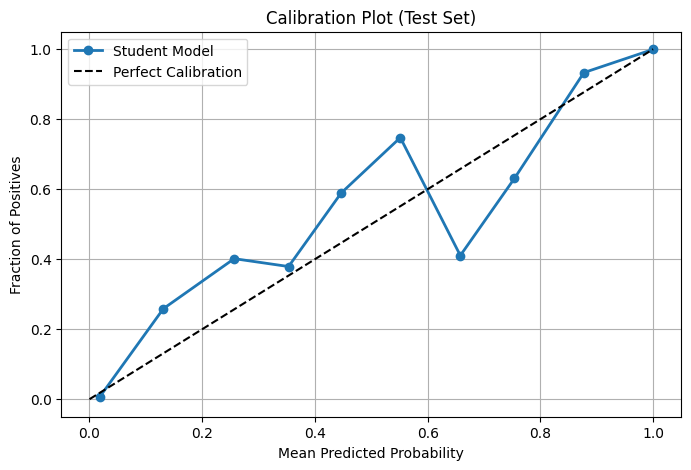

In [42]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# y_test_np : label asli
# y_student_prob : probabilitas prediksi student (0-1)

# Hitung calibration curve
prob_true, prob_pred = calibration_curve(y_test_np, y_student_prob, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label="Student Model")
plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect Calibration")

plt.title("Calibration Plot (Test Set)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.grid(True)
plt.legend()
plt.show()


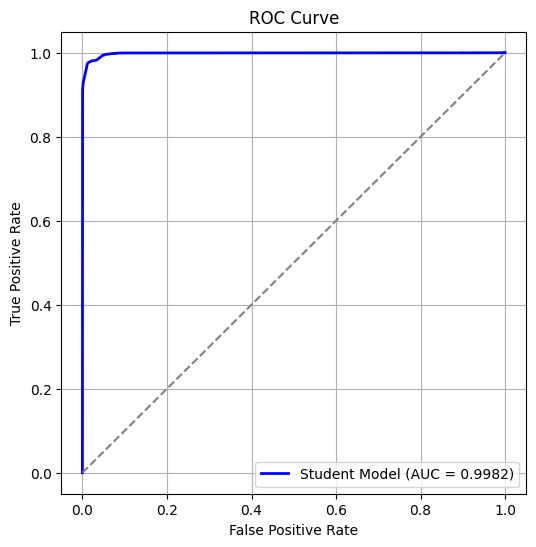

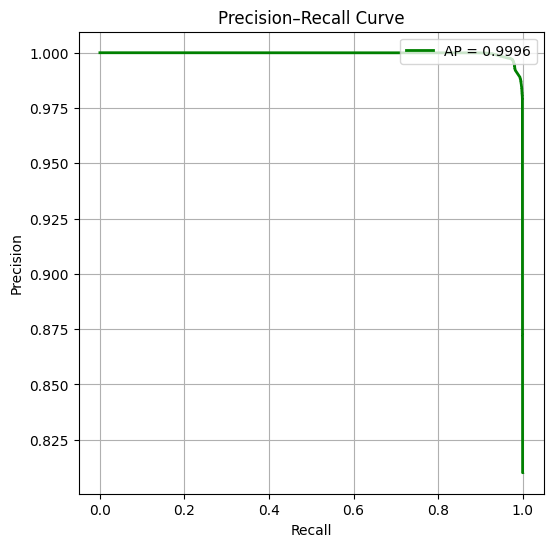

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# --- ROC Curve ---
fpr, tpr, roc_thresh = roc_curve(y_test, y_student_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Student Model (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
precision, recall, pr_thresh = precision_recall_curve(y_test, y_student_prob)
ap = average_precision_score(y_test, y_student_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [23]:
import tensorflow as tf
model_path = "../models/best.tflite"
interpreter = tf.lite.Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("INPUT DETAILS:", input_details)
print("OUTPUT DETAILS:", output_details)


INPUT DETAILS: [{'name': 'serving_default_keras_tensor_21:0', 'index': 0, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT DETAILS: [{'name': 'StatefulPartitionedCall_1:0', 'index': 13, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [24]:
import numpy as np
import pandas as pd
# ambil beberapa sample (pastikan sudah diskalakan & urutan fitur sesuai selected_features)
sample_idx = np.random.choice(len(X_test_np), size=8, replace=False)
samples = X_test_np[sample_idx].astype("float32")

# keras student predictions
keras_preds = student.predict(samples, batch_size=8).squeeze()

# tflite predictions
interpreter = tf.lite.Interpreter("../models/best.tflite")
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]

tflite_preds = []
for s in samples:
    s_in = np.expand_dims(s.astype(inp['dtype']), axis=0)
    interpreter.set_tensor(inp['index'], s_in)
    interpreter.invoke()
    t_out = interpreter.get_tensor(out['index']).squeeze()
    tflite_preds.append(float(t_out))

tflite_preds = np.array(tflite_preds)

# teacher probs (LightGBM)
teacher_probs = lgbm.predict_proba(samples)[:,1]

df = pd.DataFrame({
    "idx": sample_idx,
    "keras_student": keras_preds,
    "tflite": tflite_preds,
    "teacher_lgbm": teacher_probs
})
print(df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
      idx  keras_student    tflite  teacher_lgbm
0  265187       0.016462  0.016462      0.000015
1  509298       0.013132  0.013132      0.000015
2  527109       0.015899  0.015899      0.000166
3  484519       0.012296  0.012296      0.000008
4  485541       1.000000  1.000000      0.999531
5  151419       0.011488  0.011488      0.000004
6   76770       0.011785  0.011785      0.000138
7   86422       0.010535  0.010535      0.000001


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:
probs = student.predict(X_test_np, batch_size=2048).squeeze()
print("mean prob:", probs.mean())
print("fraction >= 0.5:", (probs>=0.5).mean())
print("fraction >= 0.735:", (probs>=0.735).mean())


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mean prob: 0.22782327
fraction >= 0.5: 0.21232900214001282
fraction >= 0.735: 0.1903636215879437


#PISAHHHHH


In [45]:
# === Cell 5: Siapkan data distillation ===

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Target: probabilitas dari LightGBM
train_probs = lgbm.predict_proba(X_train)[:, 1]
val_probs = lgbm.predict_proba(X_val)[:, 1]

print(f"Train probs shape: {train_probs.shape}, Val probs shape: {val_probs.shape}")


Train probs shape: (1771951,), Val probs shape: (442988,)


In [46]:
# === Cell 6: Train student model (Distillation Stabil & Akurat) ===

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf
import numpy as np

# Data float32
X_train_np = X_train.astype("float32").to_numpy()
X_val_np = X_val.astype("float32").to_numpy()
y_train_soft = train_probs.astype("float32")
y_val_soft = val_probs.astype("float32")

# Temperatur scaling untuk melunakkan label
T = 2.5
y_train_soft_T = np.clip(y_train_soft, 1e-6, 1-1e-6) ** (1/T)
y_val_soft_T = np.clip(y_val_soft, 1e-6, 1-1e-6) ** (1/T)

# Model student (lebih stabil & dalam sedikit)
student = Sequential([
    Input(shape=(X_train_np.shape[1],), dtype="float32"),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'  # cocok untuk meniru probabilitas teacher
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("student_best.keras", save_best_only=True, monitor='val_loss', verbose=1)
]

history = student.fit(
    X_train_np, y_train_soft_T,
    validation_data=(X_val_np, y_val_soft_T),
    batch_size=4096,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

print("✅ Training selesai. Model disimpan ke student_best.keras")


Epoch 1/50
429/433 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1472
Epoch 1: val_loss improved from None to 0.07566, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1212 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0852
Epoch 2: val_loss did not improve from 0.07566
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0876 - val_loss: 0.0875 - learning_rate: 0.0010
Epoch 3/50
428/433 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0875
Epoch 3: val_loss did not improve from 0.07566
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0872 - val_loss: 0.0873 - learning_rate: 0.0010
Epoch 4/50
432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1018
Epoch 4: val_loss improved from 0.07566 to 0.06533, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1045 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 5/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [47]:
# === Cell 7: Evaluasi student vs teacher ===
y_student_prob = student.predict(X_test.astype("float32"), batch_size=2048).squeeze()
y_student_pred = (y_student_prob > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_student_prob))
print("\nClassification Report:\n", classification_report(y_test, y_student_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_student_pred))


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC-AUC: 0.9375848352552996

Classification Report:
               precision    recall  f1-score   support

           0     0.7865    0.9583    0.8639    105159
           1     0.9897    0.9390    0.9637    448576

    accuracy                         0.9427    553735
   macro avg     0.8881    0.9487    0.9138    553735
weighted avg     0.9511    0.9427    0.9447    553735


Confusion Matrix:
 [[100778   4381]
 [ 27363 421213]]


In [4]:
import sys
path = sys.executable
!"{path}" -m pip install matplotlib


     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
      --------------------------------------- 0.1/8.1 MB 3.3 MB/s eta 0:00:03
     - -------------------------------------- 0.3/8.1 MB 5.2 MB/s eta 0:00:02
     --- ------------------------------------ 0.6/8.1 MB 5.7 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/8.1 MB 6.4 MB/s eta 0:00:02
     ------ --------------------------------- 1.2/8.1 MB 6.1 MB/s eta 0:00:02
     ------- -------------------------------- 1.5/8.1 MB 6.1 MB/s eta 0:00:02
     -------- ------------------------------- 1.7/8.1 MB 5.8 MB/s eta 0:00:02
     ---------- ----------------------------- 2.1/8.1 MB 6.0 MB/s eta 0:00:01
     ----------- ---------------------------- 2.2/8.1 MB 5.9 MB/s eta 0:00:01
     ------------ --------------------------- 2.6/8.1 MB 6.1 MB/s eta 0:00:01
     -------------- ------------------------- 2.9/8.1 MB 6.1 MB/s eta 0:00:01
     --------------- ------------------------ 3.1/8.1 MB 6.2 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


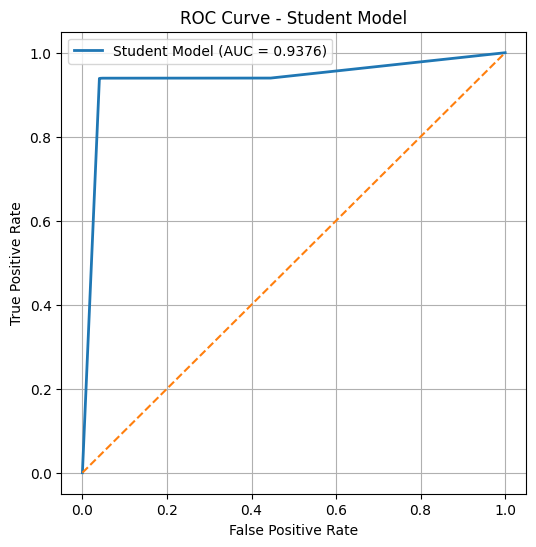

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hitung ROC curve student model
fpr, tpr, thresholds = roc_curve(y_test, y_student_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"Student Model (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title("ROC Curve - Student Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


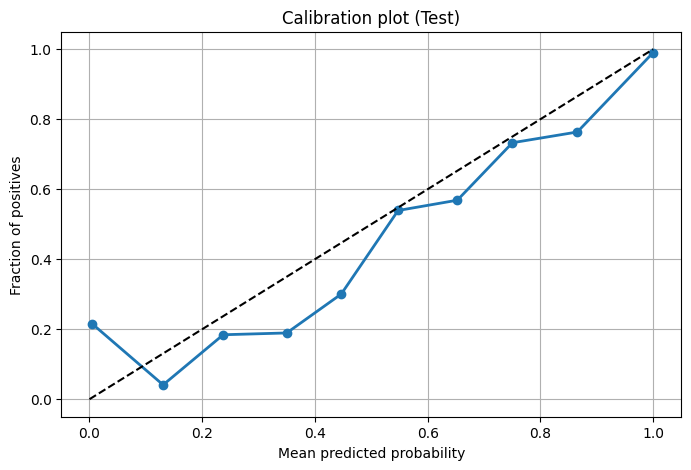

In [49]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_test      → label asli
# y_student_prob → probabilitas prediksi (0–1)

prob_true, prob_pred = calibration_curve(y_test, y_student_prob, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="black")

plt.title("Calibration plot (Test)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.grid(True)
plt.show()


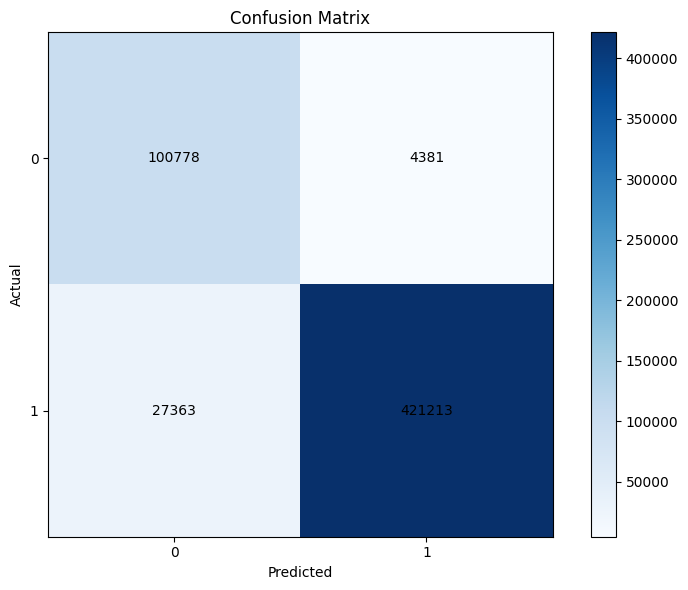

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_student_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["0", "1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Tampilkan angka
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


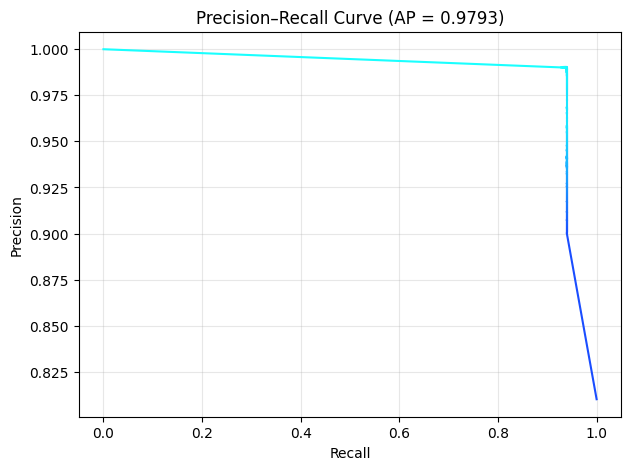

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# y_test = label aktual
# y_student_prob = probabilitas prediksi model (contoh: model.predict_proba(X_test)[:,1])

# Hitung precision, recall
precision, recall, thresholds = precision_recall_curve(y_test, y_student_prob)
ap = average_precision_score(y_test, y_student_prob)

# ---------- Plot Precision–Recall Curve ----------
plt.figure(figsize=(7,5))

# Gradasi biru-putih manual
for i in range(len(recall)-1):
    plt.plot(recall[i:i+2], precision[i:i+2],
             color=(0.1, 0.3 + 0.7*(i/len(recall)), 1.0))  # biru → putih

plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)

plt.show()


In [52]:
from tensorflow.keras.models import load_model
import os

# === Pengaturan ===
old_model_path = "student_best.keras"          # model lama hasil training
new_model_dir  = "../models"                   # folder tujuan (sudah kamu buat di GitHub)
new_model_name = "student.keras" # nama baru model

# === Buat folder kalau belum ada ===
os.makedirs(new_model_dir, exist_ok=True)

# === Load model lama ===
model = load_model(old_model_path)

# === Simpan ulang ke folder baru ===
new_model_path = os.path.join(new_model_dir, new_model_name)
model.save(new_model_path)

print(f"✅ Model berhasil disimpan ke: {new_model_path}")


✅ Model berhasil disimpan ke: ../models\student.keras


In [53]:
import tensorflow as tf

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    print("Konversi berhasil! Ukuran:", len(tflite_model))

    with open("../models/studentfair.tflite", "wb") as f:
        f.write(tflite_model)

except Exception as e:
    print("❌ ERROR saat konversi:")
    print(e)


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpca3cm2fp\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpca3cm2fp\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpca3cm2fp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1715162364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162362512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162364048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162361936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162362320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162360208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162360400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1715162359824: TensorSpec(shape=(), dtype=tf.resource, name=None)
Konversi berhasil! Ukuran: 20344


In [3]:
print("TFLite size:", len(tflite_model))


TFLite size: 20360


In [3]:
import tensorflow as tf

# Load model hasil training
model = tf.keras.models.load_model("../models/lgbmnew_student.keras")

# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Opsional) optimasi ukuran file agar ringan di deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Jalankan konversi
tflite_model = converter.convert()

# Simpan hasil konversi ke folder yang sama
with open("../models/lgbmnew_student.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke format TFLite: ../models/lgbm_studentnew.tflite")


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpf_t91wl2\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpf_t91wl2\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpf_t91wl2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1789836495184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836496144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836495760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836496720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836496336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836497296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836497104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1789836497680: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model berhasil dikonversi ke format TFLite: ../models/lgbm_studentnew.tflite


In [4]:
# Verifikasi arsitektur model TFLite
interpreter = tf.lite.Interpreter(model_path="../models/lgbmnew_student.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== Input Tensor ===")
print(input_details)
print("\n=== Output Tensor ===")
print(output_details)


=== Input Tensor ===
[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

=== Output Tensor ===
[{'name': 'StatefulPartitionedCall_1:0', 'index': 13, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [5]:
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="../models/lgbmnew_student.tflite")
interpreter.allocate_tensors()

# Ambil detail tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Buat dummy data (1 sampel, 30 fitur)
dummy_input = np.random.rand(1, 30).astype(np.float32)

# Jalankan inferensi
interpreter.set_tensor(input_details[0]['index'], dummy_input)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])

print("Output prediksi:", prediction)


Output prediksi: [[1.]]
